In [11]:
from mimiqcircuits import *
import numpy as np
from bitarray import bitarray, frozenbitarray
import matplotlib.pyplot as plt
import networkx as nx
import random
import generate

In [12]:
conn = MimiqConnection()
try:
    conn.loadtoken()
except:
    conn.savetoken()
    conn.loadtoken()

Starting authentication server on port 1444 (http://localhost:1444)


127.0.0.1 - - [07/Jun/2024 12:17:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2024 12:17:50] "GET /assets/index-07679c1c.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2024 12:17:50] "GET /assets/index-3c66e04b.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2024 12:17:50] "GET /assets/logo-141cb000.svg HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2024 12:17:50] "GET /assets/primeicons-3824be50.woff2 HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2024 12:17:55] "POST /api/login HTTP/1.1" 200 -


## Definitions of QUBO problem solvers

In [13]:
class QUBOProblem:
    def __init__(self, Q):
        if isinstance(Q, np.ndarray):
            if len(Q.shape) != 2 or Q.shape[0] != Q.shape[1]:
                raise ValueError("Q is not a valid square matrix.")
            self.Q = Q
        elif isinstance(Q, nx.Graph):
            self.Q = -nx.to_numpy_array(G)
        else:
            raise TypeError(f"Cannot build QUBO problem for object of type {typeof(Q)}")

    def _gamma(self, epsilon, lmbda, val):
        return epsilon * lmbda * val
        
    def _phaseseparator(self, c: Circuit, qubits, lmbda, epsilon):
        Q = self.Q
        for n in range(Q.shape[1]):
            for i in range(Q.shape[0]-n):
                j = i+n
                coeff1 = self.Q[i,j]
                gamma1 = self._gamma(epsilon, lmbda, coeff1)
                coeff2 = self.Q[j,i]
                gamma2 = self._gamma(epsilon, lmbda, coeff2)
                if i==j:
                    # diagonal elements
                    if gamma1 != 0:
                        c.push(GateP(gamma1), qubits[i])
                elif coeff1 == coeff2:
                    if gamma1 != 0:
                       c.push(GateCP(2*gamma1), qubits[i], qubits[j])
                else:
                    # general case!
                    if gamma1 != 0:
                        c.push(GateCP(gamma1), qubits[i], qubits[j])
                    if gamma2 != 0:
                        c.push(GateCP(gamma2), qubits[i], qubits[j])   
        return c

    def _mixer(self, c: Circuit, qubits, lmbda, epsilon):
    	c.push(GateRX(epsilon * (1 - lmbda)), qubits)
    	return c

    def _initstate(self, c: Circuit, qubits):
        # prepares the ground state of the mixer hamiltonian
        c.push(GateRY(np.pi / 2), qubits)
        return c

    def build_circuit(self, depth, epsilon=0.5):
        qubits = range(self.Q.shape[0])
        c = Circuit()
        self._initstate(c, qubits)
        for k in range(depth-1):
            lmbda = k / depth
            self._phaseseparator(c, qubits, lmbda, epsilon)
            self._mixer(c, qubits, lmbda, epsilon)
        self._phaseseparator(c, qubits, 1, epsilon)
        return c

    def energy(self, bss):
        if isinstance(bss, bitarray) or isinstance(bss, frozenbitarray):
            bbs = np.array(bss.tolist())
            return bbs.T @ self.Q @ bbs
            
        E = 0.0
        for bs in bss:
            bbs = np.array(bs.tolist())
            E += bbs.T @ self.Q @ bbs
        return E / len(bss)

    def _solve(self, conn, k, samples=1000, **kwargs):
        circ = self.build_circuit(k, **kwargs)
        job = conn.execute(circ, nsamples=samples, timelimit=30)
        res = conn.get_results(job)
        E = self.energy(res.cstates)
        hist = res.histogram()
        mps = max(hist, key=lambda k: hist[k])
        return E, mps, res

    def solve(self, conn, k, samples=1000, **kwargs):
        E, mps, _ = self._solve(conn, k, samples=samples, **kwargs)
        return E, mps

    def solve_time(self, conn, k, samples=1000, **kwargs):
        E, mps, res = self._solve(conn, k, samples=samples, **kwargs)
        return E, mps, res.timings["total"]


In [14]:
import dimod
bqm = dimod.generators.randint(100, vartype=dimod.BINARY, high=1000, low=0)
Q = bqm.to_numpy_matrix()
Q

/var/folders/y9/h6266tlx7n9bd2_vpvfqrttns60r8r/T/ipykernel_17092/1280336012.py:3: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  Q = bqm.to_numpy_matrix()


array([[771., 403., 261., ..., 186., 610., 671.],
       [  0.,  28., 439., ..., 542., 694., 772.],
       [  0.,   0., 202., ...,  28., 986., 471.],
       ...,
       [  0.,   0.,   0., ..., 512., 123., 815.],
       [  0.,   0.,   0., ...,   0., 106., 319.],
       [  0.,   0.,   0., ...,   0.,   0., 545.]])

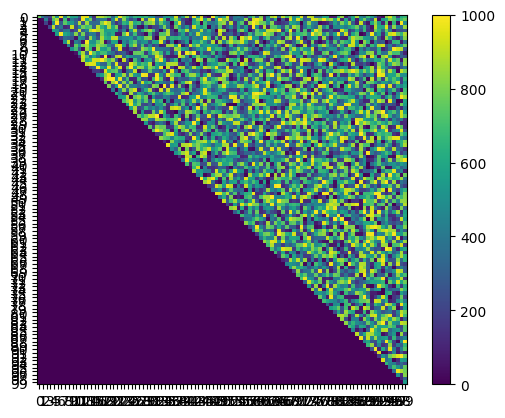

In [15]:
prob = QUBOProblem(Q)

# plot the problem
plt.imshow(prob.Q)
plt.xticks(range(prob.Q.shape[0]))
plt.yticks(range(prob.Q.shape[1]))
plt.colorbar()

In [16]:
prob.solve(conn, 40)

RuntimeError: Remote job errored: Worker stopped.

In [37]:
_, _, t = prob.solve_time(conn, 40)
print(f"Solved in {t} seconds")

Solved in 0.002555451 seconds
